<a href="https://colab.research.google.com/github/nemanja899/Sunspots-Forecasting/blob/master/Sunspots_CNN_RNN_DNN_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
sun_df=pd.read_csv("./drive/MyDrive/ColabNotebooks/Dataset/sunspots/Sunspots.csv",index_col=0,parse_dates=["Date"])

In [ ]:
# Download the Dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv
sun_df2=pd.read_csv('./Sunspots.csv',index_col=0,parse_dates=["Date"])

--2022-05-27 11:56:29--  https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.192.128, 209.85.147.128, 142.250.148.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.192.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [text/csv]
Saving to: ‘Sunspots.csv’

Sunspots.csv        100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2022-05-27 11:56:29 (95.5 MB/s) - ‘Sunspots.csv’ saved [70827/70827]



In [ ]:
sun_df=sun_df.rename(columns={"Monthly Mean Total Sunspot Number":"Monthly_Sunspots"})

In [ ]:
sun_df = sun_df.set_index("Date").to_period("M")

In [ ]:
sun_df.index=sun_df.index.to_timestamp()

In [ ]:
Y_train=sun_df.loc[:'1969-1']
Y_test=sun_df.loc['1969-2':]

In [ ]:
def plot_time_series(time_series, format="-",title=None):
    plt.figure(figsize=(20,5))
    plt.grid()
    plt.plot(time_series['Monthly_Sunspots'], label='True value')
    plt.plot(time_series['Forecast'], label='Predicted values')
    plt.legend(loc='best')
    plt.title(title)
    plt.show()

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generise dataset kao okvir (window) na pr od 1234556789 on pravi ,ako je window 5: [1,2,3,4,5],[2,3,4,5,6],[3,4,5,6,7],[4,5,6,7,8],[5,6,7,8,9] ...

    Args:
      series (array of float) - vrednosti dataseta
      window_size (int) - welicina okvira
      batch_size (int) - velicina bacha
      shuffle_buffer(int) - velicina bufera

    Returns:
      dataset (TF Dataset) -vraca tensor flow dataset
    """
  
    # Generise tensor flow dataset
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Pravi window dataset +1 jer zadnji broj sluzi za predikciju, shift pomera za 1, drop reminder odbacuje ostatak
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [ ]:
# parametri
window_size = 30
batch_size = 36
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(Y_train.Monthly_Sunspots, window_size, batch_size, shuffle_buffer_size)

In [ ]:
# Build the Model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

 # Print the model summary 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 30, 32)            12416     
                                                                 
 lstm_1 (LSTM)               (None, 30, 32)            8320      
                                                                 
 lstm_2 (LSTM)               (None, 30, 32)            8320      
                                                                 
 lstm_3 (LSTM)               (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 10)                3

In [ ]:

init_weights = model.get_weights()

In [ ]:
# Podesava callback za optimizaciju ucenja
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Inicijalizuje stohasticki gradijent
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Podesava parametre, huber jer je on otporan na outlajere
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Trenira model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
73/73 [==============================] - 13s 66ms/step - loss: 79.4956 - lr: 1.0000e-08
Epoch 2/100
73/73 [==============================] - 6s 79ms/step - loss: 75.8044 - lr: 1.1220e-08
Epoch 3/100
73/73 [==============================] - 5s 65ms/step - loss: 72.2991 - lr: 1.2589e-08
Epoch 4/100
73/73 [==============================] - 5s 65ms/step - loss: 69.0408 - lr: 1.4125e-08
Epoch 5/100
73/73 [==============================] - 5s 65ms/step - loss: 66.1081 - lr: 1.5849e-08
Epoch 6/100
73/73 [==============================] - 5s 66ms/step - loss: 63.4808 - lr: 1.7783e-08
Epoch 7/100
73/73 [==============================] - 5s 65ms/step - loss: 60.9193 - lr: 1.9953e-08
Epoch 8/100
73/73 [==============================] - 5s 65ms/step - loss: 58.5754 - lr: 2.2387e-08
Epoch 9/100
73/73 [==============================] - 5s 65ms/step - loss: 56.6190 - lr: 2.5119e-08
Epoch 10/100
73/73 [==============================] - 5s 66ms/step - loss: 54.9372 - lr: 2.8184e-08
Epoch 11

(1e-08, 0.001, 0.0, 100.0)

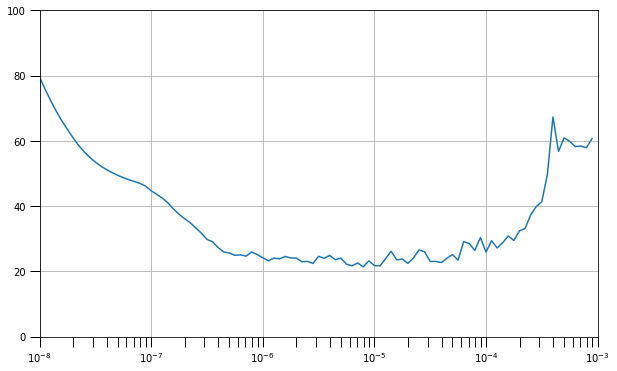

In [ ]:
# niz brojeva ucenja za koje smo optimizovali
lrs = 1e-8 * (10 ** (np.arange(100) / 20))


plt.figure(figsize=(10, 6))
plt.grid(True)
plt.semilogx(lrs, history.history["loss"])
plt.tick_params('both', length=10, width=1, which='both')

# postavljenje granice
plt.axis([1e-8, 1e-3, 0, 100])

# Iz grafika sada biramo optimalan learning rate!!! Naci minimalnu tacku i  taj learning rate ce da koristimo za krajnji model

In [ ]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [ ]:
#optimalan learning rate
learning_rate = 2e-6

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [ ]:
# Train the model
history = model.fit(train_set,epochs=500)

Epoch 1/500
73/73 [==============================] - 12s 66ms/step - loss: 49.3685 - mae: 49.8660
Epoch 2/500
73/73 [==============================] - 5s 66ms/step - loss: 34.1199 - mae: 34.6153
Epoch 3/500
73/73 [==============================] - 5s 66ms/step - loss: 26.8003 - mae: 27.2950
Epoch 4/500
73/73 [==============================] - 5s 66ms/step - loss: 25.5223 - mae: 26.0185
Epoch 5/500
73/73 [==============================] - 5s 65ms/step - loss: 25.6013 - mae: 26.0959
Epoch 6/500
73/73 [==============================] - 5s 65ms/step - loss: 25.8312 - mae: 26.3269
Epoch 7/500
73/73 [==============================] - 5s 65ms/step - loss: 24.0981 - mae: 24.5926
Epoch 8/500
73/73 [==============================] - 5s 66ms/step - loss: 24.2259 - mae: 24.7200
Epoch 9/500
73/73 [==============================] - 5s 66ms/step - loss: 23.4760 - mae: 23.9704
Epoch 10/500
73/73 [==============================] - 5s 65ms/step - loss: 23.1593 - mae: 23.6525
Epoch 11/500
73/73 [========

In [ ]:
def plot_series(time, series, format="-",title=None,xlabel=None,ylabel=None,legend=None, start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)
    plt.title(title)
    # Overlay a grid on the graph
    plt.grid(True)
    plt.legend(legend)

    # Draw the graph on screen
    plt.show()

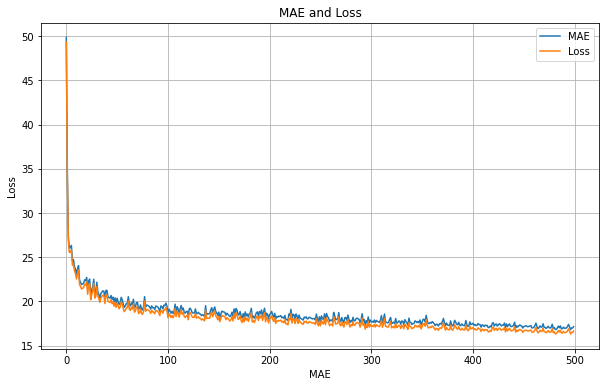

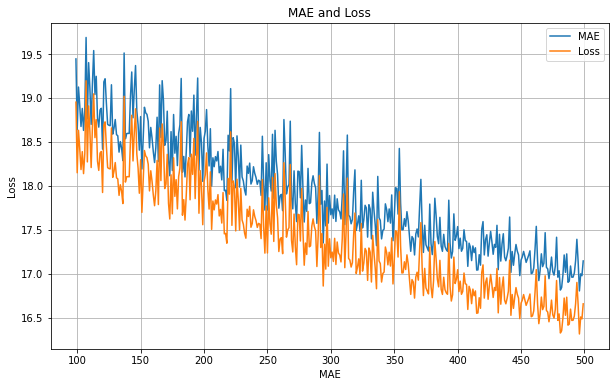

In [ ]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    time=epochs, 
    series=(mae, loss), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    time=epochs_zoom, 
    series=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

In [ ]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

In [ ]:
forecast = model_forecast(model, sun_df.iloc[Y_train.shape[0]-window_size+1:,-1], window_size, batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


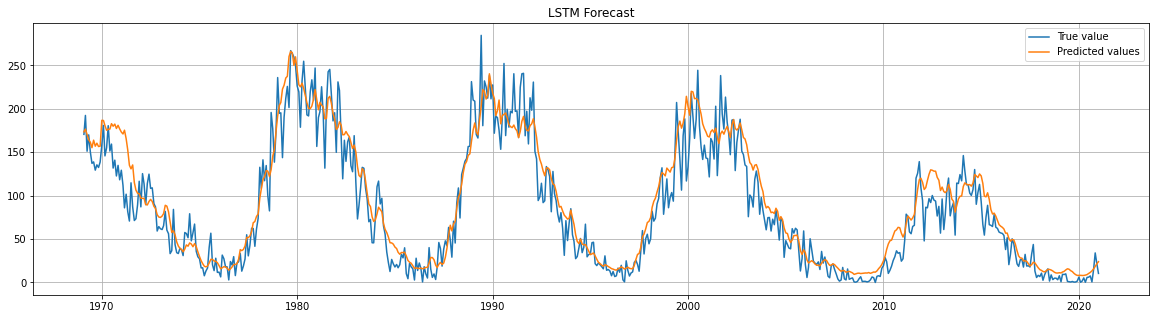

In [ ]:


# Drop single dimensional axis
Y_test["Forecast"]=results = forecast.squeeze()

# Plot the results
plot_time_series(Y_test,title="LSTM Forecast")

In [ ]:
# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(Y_test.Monthly_Sunspots,Y_test.Forecast).numpy())

17.258965


In [ ]:
# Set the initial learning rate
initial_learning_rate=1e-7

# Define the scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=400,
    decay_rate=0.96,
    staircase=True)

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=500)

Epoch 1/500
73/73 [==============================] - 13s 66ms/step - loss: 69.9333 - mae: 70.4296
Epoch 2/500
73/73 [==============================] - 5s 71ms/step - loss: 56.1222 - mae: 56.6209
Epoch 3/500
73/73 [==============================] - 9s 109ms/step - loss: 51.5182 - mae: 52.0164
Epoch 4/500
73/73 [==============================] - 5s 66ms/step - loss: 49.4563 - mae: 49.9541
Epoch 5/500
73/73 [==============================] - 5s 65ms/step - loss: 48.2255 - mae: 48.7233
Epoch 6/500
73/73 [==============================] - 6s 85ms/step - loss: 47.4384 - mae: 47.9364
Epoch 7/500
73/73 [==============================] - 8s 102ms/step - loss: 46.7484 - mae: 47.2459
Epoch 8/500
73/73 [==============================] - 5s 66ms/step - loss: 45.7720 - mae: 46.2687
Epoch 9/500
73/73 [==============================] - 5s 66ms/step - loss: 44.3079 - mae: 44.8054
Epoch 10/500
73/73 [==============================] - 5s 67ms/step - loss: 43.3453 - mae: 43.8422
Epoch 11/500
73/73 [======

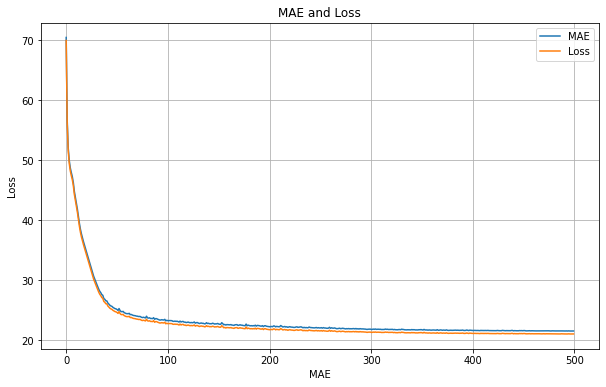

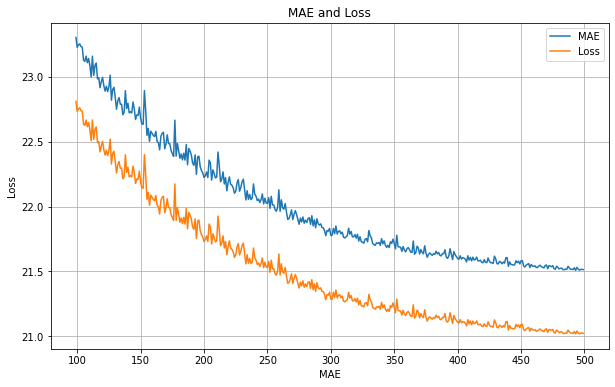

In [ ]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    time=epochs, 
    series=(mae, loss), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    time=epochs_zoom, 
    series=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

In [ ]:
forecast = model_forecast(model, sun_df.iloc[Y_train.shape[0]-window_size+1:,-1], window_size, batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


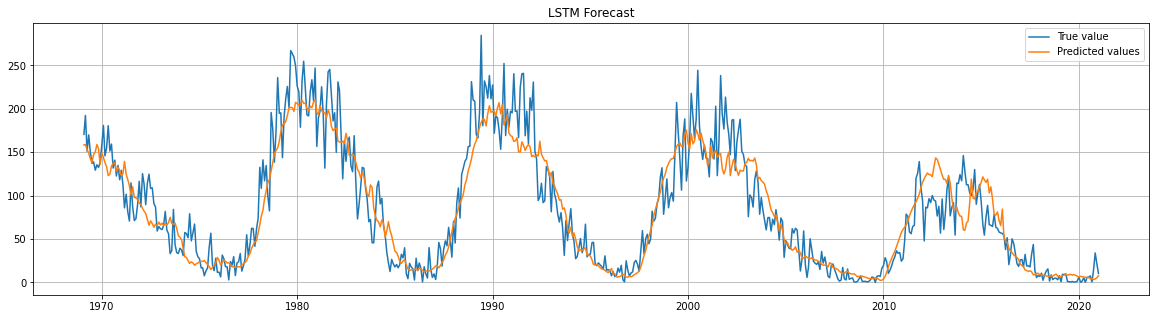

In [ ]:
# Drop single dimensional axis
Y_test["Forecast"]=results = forecast.squeeze()

# Plot the results
plot_time_series(Y_test,title="LSTM Forecast")

In [ ]:
# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(Y_test.Monthly_Sunspots,Y_test.Forecast).numpy())

19.87573
